<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/XLK_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Import required libraries

In [1]:
# Import required libraries

!pip install pycaret yellowbrick
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
import pycaret
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from yellowbrick.regressor import PredictionError

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4015    0  4015    0     0   6341      0 --:--:-- --:--:-- --:--:--  6342
100  517k  100  517k    0     0   388k      0  0:00:01  0:00:01 --:--:--  388k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4027    0  4027    0     0  14387      0 --:--:-- --:--:-- --:--:-- 14433
100  392k  100  392k    0     0   616k      0 --:--:-- --:--:-- --:--:--  616k


#Step 2: Download Data

In [2]:
# Download historical data

ticker = "XLK"
df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
df.reset_index(inplace=True)

# Remove any multi-level headers by flattening the columns
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

[*********************100%***********************]  1 of 1 completed


# Step 3: Define Functions for Technical Indicators and Data Preparation

In [3]:
def add_technical_indicators(df):
    # Relative Strength Index (RSI)
    df['RSI'] = talib.RSI(df['Adj Close'], timeperiod=14)

    # Moving Average Convergence Divergence (MACD)
    df['MACD'], df['MACD_signal'], df['MACD_diff'] = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    # Average True Range (ATR)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

    # Bollinger Bands (BBANDS)
    df['bb_bbm'], df['bb_bbh'], df['bb_bbl'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    # Keltner Channel (KC)
    df['EMA_KC'] = talib.EMA(df['Adj Close'], timeperiod=20)
    df['KC_upper'] = df['EMA_KC'] + (df['ATR'] * 1.5)
    df['KC_lower'] = df['EMA_KC'] - (df['ATR'] * 1.5)
    df['KC'] = (df['Adj Close'] - df['KC_upper']) / df['Adj Close']
    df.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

    # Donchian Channel (DC)
    df['DC_upper'] = df['High'].rolling(window=20).max()
    df['DC_lower'] = df['Low'].rolling(window=20).min()
    df['DC_middle'] = (df['DC_upper'] + df['DC_lower']) / 2

    # On-Balance Volume (OBV)
    df['OBV'] = talib.OBV(df['Adj Close'], df['Volume'])

    # Chaikin Money Flow (CMF)
    cmf_period = 20
    df['Money_Flow_Multiplier'] = ((df['Adj Close'] - df['Low']) - (df['High'] - df['Adj Close'])) / (df['High'] - df['Low'])
    df['Money_Flow_Volume'] = df['Money_Flow_Multiplier'] * df['Volume']
    df['CMF'] = df['Money_Flow_Volume'].rolling(window=cmf_period).sum() / df['Volume'].rolling(window=cmf_period).sum()
    df.drop(columns=['Money_Flow_Multiplier', 'Money_Flow_Volume'], inplace=True)

    # Stochastic Oscillator
    df['stoch_k'], df['stoch_d'] = talib.STOCH(df['High'], df['Low'], df['Adj Close'],
                                               fastk_period=14, slowk_period=3, slowk_matype=0,
                                               slowd_period=3, slowd_matype=0)

    # Average Directional Index (ADX)
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

    return df

def add_lagged_features(df, features, lag_days=20):
    for feature in features:
        for lag in range(1, lag_days + 1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    df.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return df

# Add Technical Indicators to the Data
df = add_technical_indicators(df)

# Add Lagged Features and Drop Non-Lagged Columns
# Specify features to lag
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR',
                   'bb_bbm', 'bb_bbh', 'bb_bbl', 'KC', 'DC_upper', 'DC_lower',
                   'DC_middle', 'OBV', 'CMF', 'stoch_k', 'stoch_d', 'ADX']
df = add_lagged_features(df, features_to_lag)

# Drop non-lagged columns after adding lags
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD',
                   'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC', 'DC_upper', 'DC_lower', 'DC_middle',
                   'OBV', 'CMF', 'Money_Flow_Multiplier', 'Money_Flow_Volume',
                   'stoch_k', 'stoch_d', 'ADX']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Data is now prepared
print("Processed Data:")
print(df.head())

Processed Data:
                        Date  Adj Close  Volume_lag_1  Volume_lag_2  \
53 2012-03-20 00:00:00+00:00  25.272032     8930800.0     9478800.0   
54 2012-03-21 00:00:00+00:00  25.263615     5713100.0     8930800.0   
55 2012-03-22 00:00:00+00:00  25.204788     8825000.0     5713100.0   
56 2012-03-23 00:00:00+00:00  25.204788     7500900.0     8825000.0   
57 2012-03-26 00:00:00+00:00  25.574574     9511600.0     7500900.0   

    Volume_lag_3  Volume_lag_4  Volume_lag_5  Volume_lag_6  Volume_lag_7  \
53    12450500.0    12741800.0    19012100.0     5926800.0     6365800.0   
54     9478800.0    12450500.0    12741800.0    19012100.0     5926800.0   
55     8930800.0     9478800.0    12450500.0    12741800.0    19012100.0   
56     5713100.0     8930800.0     9478800.0    12450500.0    12741800.0   
57     8825000.0     5713100.0     8930800.0     9478800.0    12450500.0   

    Volume_lag_8  ...  ADX_lag_11  ADX_lag_12  ADX_lag_13  ADX_lag_14  \
53     7258900.0  ...   59.

# Step 4: Split Data into Training, Validation, and Test Sets

In [4]:
train_data = df[df['Date'] < "2022-01-01"].set_index('Date')
validation_data = df[(df['Date'] >= "2022-01-01") & (df['Date'] < "2023-01-01")].set_index('Date')
test_data = df[df['Date'] >= "2023-01-01"].set_index('Date')

# Step 5: Feature Selection with RandomForestRegressor


Selected Important Features:
['bb_bbl_lag_1', 'bb_bbl_lag_2', 'bb_bbl_lag_3', 'DC_lower_lag_1', 'DC_middle_lag_1', 'DC_middle_lag_2']


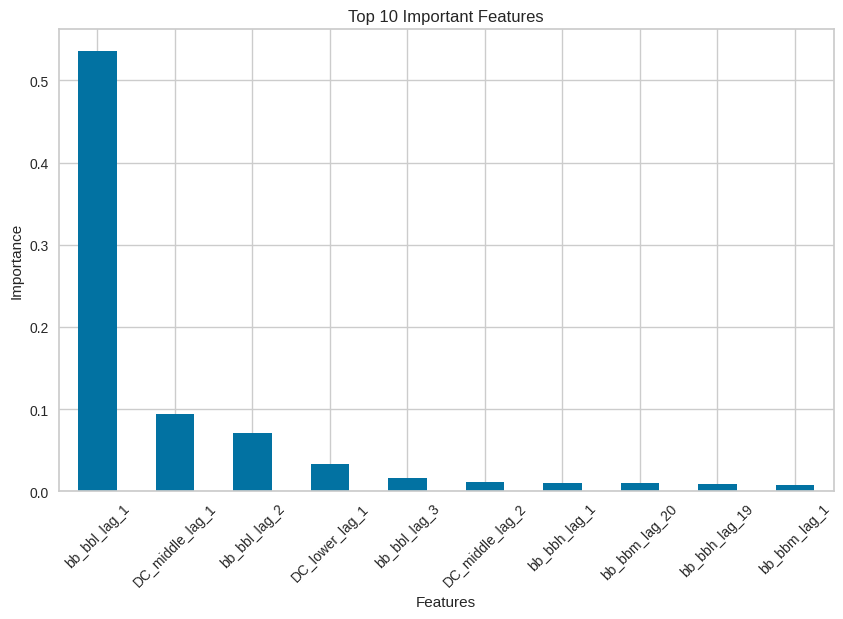

In [5]:
X_train = train_data.drop(columns=['Adj Close'])
y_train = train_data['Adj Close']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Select important features
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
important_features = feature_importances[feature_importances > 0.01].index.tolist()

print("Selected Important Features:")
print(important_features)

# Sort feature importances and select the top 10
top_10_features = feature_importances.sort_values(ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='bar')
plt.title("Top 10 Important Features")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


In [6]:
# Filter train, validation, and test data to include only important features
train_data_filtered = train_data[important_features + ['Adj Close']]
validation_data_filtered = validation_data[important_features + ['Adj Close']]
test_data_filtered = test_data[important_features + ['Adj Close']]

# Step 6: Train Model Using PyCaret with Selected Features


In [7]:
regression_setup = setup(
    data=train_data_filtered,
    target='Adj Close',
    fold_strategy='timeseries',
    fold=5,
    session_id=42,
    data_split_shuffle=False,
    fold_shuffle=False,
    verbose=False
)

best_model = compare_models(sort='RMSE')
tuned_model = tune_model(best_model, optimize='RMSE', fold=5)
final_model = finalize_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.7874,1.3005,1.0344,0.8293,0.0227,0.0177,0.9400
br,Bayesian Ridge,0.7905,1.3010,1.0361,0.8290,0.0228,0.0178,0.0660
ridge,Ridge Regression,0.8273,1.2980,1.0529,0.8250,0.0234,0.0190,0.0260
huber,Huber Regressor,0.8061,1.4022,1.0719,0.8142,0.0236,0.0181,0.1180
omp,Orthogonal Matching Pursuit,1.1433,2.2092,1.4128,0.6215,0.0340,0.0280,0.0480
par,Passive Aggressive Regressor,1.2210,2.3837,1.4639,0.6001,0.0331,0.0277,0.0500
en,Elastic Net,1.7448,6.0328,2.0496,-0.2273,0.0560,0.0473,0.0480
lasso,Lasso Regression,1.8940,7.0453,2.1933,-0.4627,0.0608,0.0517,0.0340
llar,Lasso Least Angle Regression,1.8942,7.0464,2.1934,-0.4624,0.0608,0.0517,0.0620
dt,Decision Tree Regressor,4.2086,29.1982,4.9673,-2.0932,0.1128,0.0926,0.0340


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4516,0.3055,0.5527,0.9328,0.0179,0.0150
1,0.5658,0.4970,0.7050,0.7737,0.0188,0.0156
2,0.8684,1.5248,1.2348,0.7380,0.0321,0.0228
3,0.6628,0.6376,0.7985,0.9714,0.0156,0.0131
4,1.3883,3.5378,1.8809,0.7307,0.0293,0.0221
Mean,0.7874,1.3005,1.0344,0.8293,0.0227,0.0177
Std,0.3301,1.1942,0.4802,0.1020,0.0067,0.0040


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


# Step 7: Evaluate Model on Validation and Test Data


Model Used: Pipeline

Validation Set Evaluation Scores:
RMSE: 5.5150
R²: 0.8113

Test Set Evaluation Scores:
RMSE: 4.8789
R²: 0.9234

Features Used:
['bb_bbl_lag_1', 'bb_bbl_lag_2', 'bb_bbl_lag_3', 'DC_lower_lag_1', 'DC_middle_lag_1', 'DC_middle_lag_2']


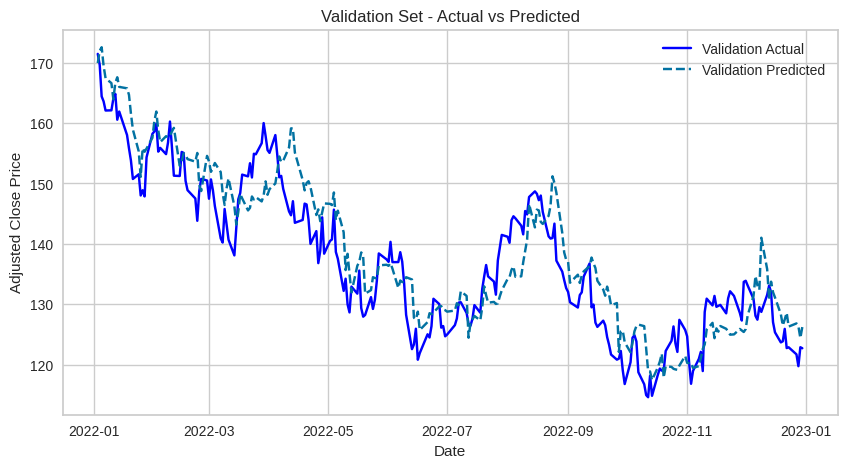

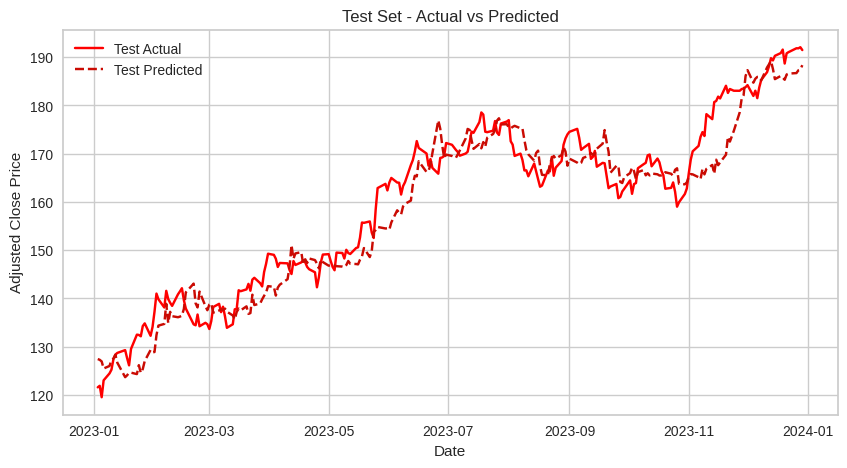

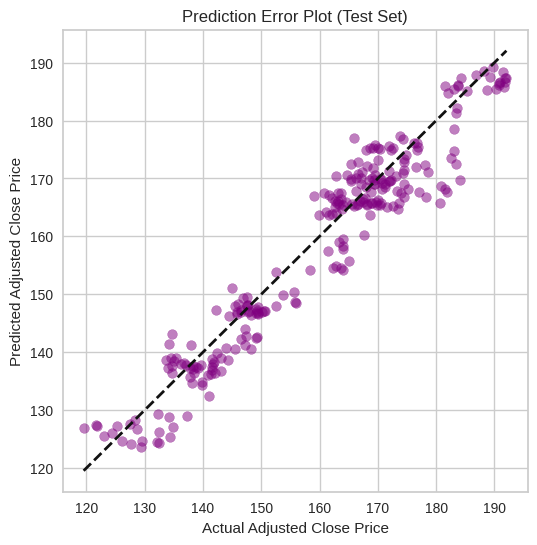

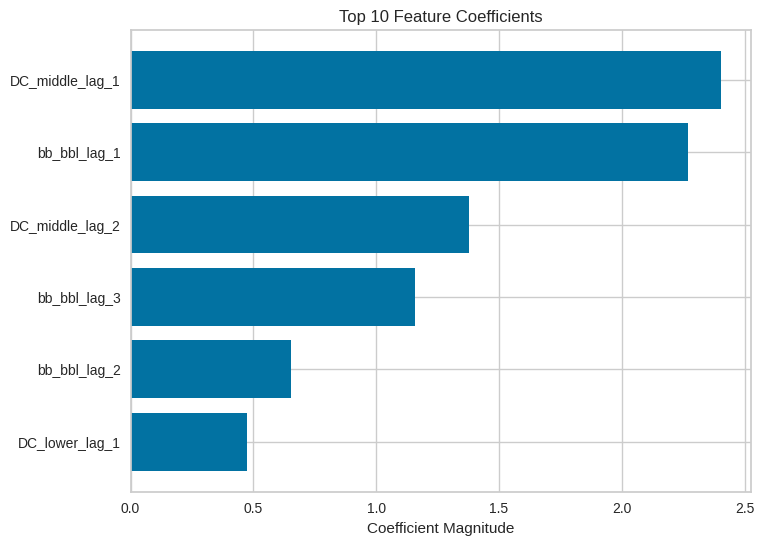

In [8]:
def evaluate_model_separate_plots(model, validation_data, test_data, target, features):

    # Ensure the Date index or column is retained in validation and test data
    validation_data = validation_data.reset_index()
    test_data = test_data.reset_index()

    # Extract actual and predicted values for validation data
    validation_y = validation_data[target]
    validation_predictions = predict_model(model, data=validation_data.drop(columns=[target]))['prediction_label']

    # Extract actual and predicted values for test data
    test_y = test_data[target]
    test_predictions = predict_model(model, data=test_data.drop(columns=[target]))['prediction_label']

    # Calculate RMSE and R² scores for validation
    val_rmse = np.sqrt(mean_squared_error(validation_y, validation_predictions))
    val_r2 = r2_score(validation_y, validation_predictions)

    # Calculate RMSE and R² scores for test
    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
    test_r2 = r2_score(test_y, test_predictions)

    # Model name
    model_name = str(model).split("(")[0]  # Get model name from the model object

    # Print the model, evaluation scores, and features used
    print("Model Used:", model_name)
    print("\nValidation Set Evaluation Scores:")
    print(f"RMSE: {val_rmse:.4f}")
    print(f"R²: {val_r2:.4f}")

    print("\nTest Set Evaluation Scores:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"R²: {test_r2:.4f}")

    print("\nFeatures Used:")
    print(features)

    # Plot Validation Data
    plt.figure(figsize=(10, 5))
    plt.plot(validation_data['Date'], validation_y, label="Validation Actual", color='blue')
    plt.plot(validation_data['Date'], validation_predictions, 'b--', label="Validation Predicted")  # Dotted line for prediction
    plt.title("Validation Set - Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.legend()
    plt.show()

    # Plot Test Data
    plt.figure(figsize=(10, 5))
    plt.plot(test_data['Date'], test_y, label="Test Actual", color='red')
    plt.plot(test_data['Date'], test_predictions, 'r--', label="Test Predicted")  # Dotted line for prediction
    plt.title("Test Set - Actual vs Predicted")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.legend()
    plt.show()

    # Prediction Error Plot for Test Set
    plt.figure(figsize=(6, 6))
    plt.scatter(test_y, test_predictions, alpha=0.5, color='purple')
    plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=2)
    plt.title("Prediction Error Plot (Test Set)")
    plt.xlabel("Actual Adjusted Close Price")
    plt.ylabel("Predicted Adjusted Close Price")
    plt.show()

    # Feature Importance Plot (only if the model supports feature importances or coefficients)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel("Feature Importance")
        plt.title("Top 10 Feature Importances")
        plt.show()
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        indices = np.argsort(importances)[-10:]  # Top 10 features
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel("Coefficient Magnitude")
        plt.title("Top 10 Feature Coefficients")
        plt.show()

# Call the function with the final model, validation, and test data, and the list of important features
evaluate_model_separate_plots(final_model, validation_data_filtered, test_data_filtered, 'Adj Close', important_features)



#Generate Buy/Sell Signals for Predicted Price

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.9690,23.8035,4.8789,0.9234,0.0307,0.0250


Trade Results:
Total Profit/Loss: 63.48
Number of Trades Executed: 40
Average Profit per Trade: 1.59

Trade Details:
                    Buy Date                 Sell Date   Buy Price  \
0  2023-01-23 00:00:00+00:00 2023-01-24 00:00:00+00:00  132.484680   
1  2023-01-26 00:00:00+00:00 2023-02-07 00:00:00+00:00  134.259949   
2  2023-01-27 00:00:00+00:00 2023-02-07 00:00:00+00:00  134.822113   
3  2023-02-01 00:00:00+00:00 2023-02-07 00:00:00+00:00  137.248322   
4  2023-02-02 00:00:00+00:00 2023-02-07 00:00:00+00:00  140.996124   
5  2023-02-06 00:00:00+00:00 2023-02-07 00:00:00+00:00  138.116226   
6  2023-02-08 00:00:00+00:00 2023-02-21 00:00:00+00:00  139.861908   
7  2023-02-15 00:00:00+00:00 2023-02-21 00:00:00+00:00  142.110626   
8  2023-02-16 00:00:00+00:00 2023-02-21 00:00:00+00:00  139.644943   
9  2023-02-17 00:00:00+00:00 2023-02-21 00:00:00+00:00  137.899277   
10 2023-02-23 00:00:00+00:00 2023-02-24 00:00:00+00:00  136.656570   
11 2023-03-14 00:00:00+00:00 2023-03-20 00:

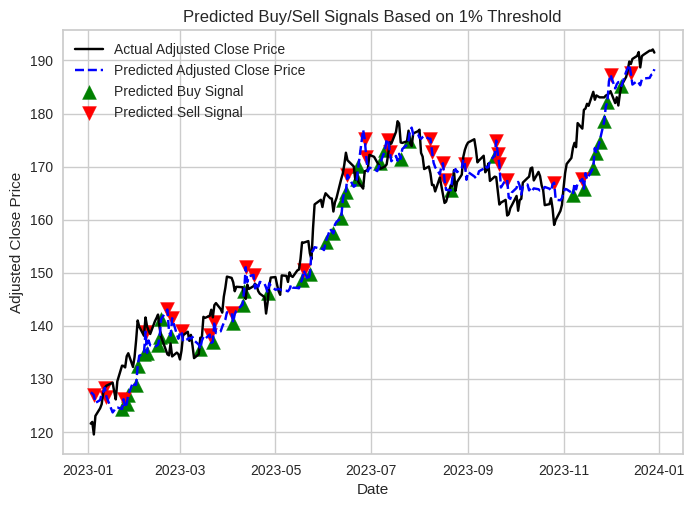

In [9]:
# Predict on the test data
test_data_predicted = predict_model(final_model, data=test_data_filtered)

# Calculate the percentage change in predictions to assess trend
test_data_predicted['Next_Prediction'] = test_data_predicted['prediction_label'].shift(-1)
test_data_predicted['Predicted_Percent_Change'] = (
    (test_data_predicted['Next_Prediction'] - test_data_predicted['prediction_label']) /
    test_data_predicted['prediction_label']
) * 100

# Generate buy/sell signals based on the predicted percentage change
buy_threshold = 1.0  # 1% increase as a buy signal
sell_threshold = -1.0  # -1% decrease as a sell signal

# Default no signal
test_data_predicted['Signal'] = 0
test_data_predicted.loc[test_data_predicted['Predicted_Percent_Change'] >= buy_threshold, 'Signal'] = 1  # Buy signal
test_data_predicted.loc[test_data_predicted['Predicted_Percent_Change'] <= sell_threshold, 'Signal'] = -1  # Sell signal

# Evaluate the strategy on actual prices

# Initialize lists to track trade details
trade_dates = []
buy_prices = []
sell_prices = []
profits = []

# Track all open buy positions
positions = []  # Store tuples of (buy_price, buy_date)

for i in range(len(test_data_predicted)):
    # Get the predicted signal, actual price, and date
    signal = test_data_predicted['Signal'].iloc[i]
    actual_price = test_data_filtered['Adj Close'].iloc[i]
    date = test_data_filtered.index[i]  # Get the date from the original data

    # If it's a buy signal, buy one stock at the actual price
    if signal == 1:
        positions.append((actual_price, date))  # Store each buy price and date

    # If it's a sell signal, sell all open positions
    elif signal == -1 and positions:
        # Execute a trade for each open position
        for buy_price, buy_date in positions:
            profit = actual_price - buy_price  # Calculate profit for each position

            # Record trade details
            trade_dates.append((buy_date, date))  # Record buy and sell dates
            buy_prices.append(buy_price)
            sell_prices.append(actual_price)
            profits.append(profit)

        # Clear all open positions after selling
        positions = []

# Calculate total profit or loss
total_profit = sum(profits)

# Create a DataFrame to display trade details
trade_df = pd.DataFrame({
    'Buy Date': [date[0] for date in trade_dates],
    'Sell Date': [date[1] for date in trade_dates],
    'Buy Price': buy_prices,
    'Sell Price': sell_prices,
    'Profit': profits
})

# Display trade results
print("Trade Results:")
print(f"Total Profit/Loss: {total_profit:.2f}")
print(f"Number of Trades Executed: {len(profits)}")
print(f"Average Profit per Trade: {total_profit / len(profits) if profits else 0:.2f}")

# Show trade details
print("\nTrade Details:")
print(trade_df)

# Plot actual adjusted close prices
plt.plot(test_data_filtered.index, test_data_filtered['Adj Close'], label="Actual Adjusted Close Price", color='black')
# Plot predicted adjusted close prices
plt.plot(test_data_predicted.index, test_data_predicted['prediction_label'], label="Predicted Adjusted Close Price", color='blue', linestyle='--')

# Mark buy and sell signals on predicted data
plt.scatter(test_data_predicted[test_data_predicted['Signal'] == 1].index,
            test_data_predicted[test_data_predicted['Signal'] == 1]['prediction_label'],
            marker='^', color='green', label='Predicted Buy Signal', s=100)
plt.scatter(test_data_predicted[test_data_predicted['Signal'] == -1].index,
            test_data_predicted[test_data_predicted['Signal'] == -1]['prediction_label'],
            marker='v', color='red', label='Predicted Sell Signal', s=100)

plt.title("Predicted Buy/Sell Signals Based on 1% Threshold")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()